### Imports

In [1]:
# Libraries
import os
from importlib import reload

import tensorflow as tf
import keras
import sklearn.model_selection

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Scripts
from helpers import data, runners, utils, generators

In [2]:
!pip show tensorflow # Should be v2.10

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras # Should be v2.10

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(runners)
reload(data)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

In [6]:
NUM_EPOCHS = 50
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 4

### Load data

In [7]:
pairs_df = pd.read_csv("../data/DATASET_CSVS/deepship_pairs_diff_recording.csv")

print(pairs_df.shape)

(12880, 5)


In [8]:
# ADD RELATIVE PATH

PATH_TO_ROOT = "..\\data\\"
pairs_df["file_path_1"] = pairs_df["file_path_1"].apply(
    lambda x: PATH_TO_ROOT + x
)
pairs_df["file_path_2"] = pairs_df["file_path_2"].apply(
    lambda x: PATH_TO_ROOT + x
)

pairs_df.head(2)

ship_name                                        file_path_1  date_seg_1  \
0  ALFRED_N  ..\data\deepship_baseline_mat\Tanker\ALFRED_N-...  20170326_1   
1  ALFRED_N  ..\data\deepship_baseline_mat\Tanker\ALFRED_N-...  20170326_2   

                                         file_path_2   date_seg_2  
0  ..\data\deepship_baseline_mat\Tanker\ALFRED_N-...  20170403_51  
1  ..\data\deepship_baseline_mat\Tanker\ALFRED_N-...  20170403_48

In [9]:
# Get train-validate-test splits

train_df, test_df = sklearn.model_selection.train_test_split(
    pairs_df,
    test_size=0.2,
    random_state=100,
    shuffle=True
)

val_df, test_df = sklearn.model_selection.train_test_split(
    test_df,
    test_size=0.5,
    random_state=100,
    shuffle=True
)

In [10]:
# Initialise generators
train_gen = generators.N2NGenerator(
    train_df,
    'mat',
    'Ptrans',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

val_gen = generators.N2NGenerator(
    val_df,
    'mat',
    'Ptrans',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

test_gen = generators.N2NGenerator(
    test_df,
    'mat',
    'Ptrans',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

### Initialise model

In [11]:
# model = keras.saving.load_model('models/saved/n2n_finetuned_25112024/n2n_finetuned.keras')

from models import irfan_2020, unet_n2n, unetpro

model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
# model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr]
)

model.summary()

Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3

### Train model

In [12]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="models/saved/diff_spec_denoiser_05122024/irfan/{epoch:02d}.keras",
    monitor='val_psnr',
    mode='max',
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/diff_spec_denoiser_05122024/irfan/training.log",
    separator=",",
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/diff_spec_denoiser_05122024/irfan/tmp"
)

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, csv_logger, backup_callback],
    verbose=2
)

Epoch 1/50
644/644 - 186s - loss: 0.0285 - psnr: 15.8728 - val_loss: 0.0232 - val_psnr: 16.5991 - 186s/epoch - 289ms/step
Epoch 2/50
644/644 - 112s - loss: 0.0219 - psnr: 16.8552 - val_loss: 0.0219 - val_psnr: 16.8800 - 112s/epoch - 174ms/step
Epoch 3/50
644/644 - 115s - loss: 0.0215 - psnr: 16.9398 - val_loss: 0.0216 - val_psnr: 16.9421 - 115s/epoch - 179ms/step
Epoch 4/50
644/644 - 114s - loss: 0.0213 - psnr: 16.9826 - val_loss: 0.0215 - val_psnr: 16.9586 - 114s/epoch - 176ms/step
Epoch 5/50
644/644 - 209s - loss: 0.0212 - psnr: 17.0008 - val_loss: 0.0214 - val_psnr: 16.9752 - 209s/epoch - 324ms/step
Epoch 6/50
644/644 - 189s - loss: 0.0211 - psnr: 17.0198 - val_loss: 0.0214 - val_psnr: 16.9557 - 189s/epoch - 293ms/step
Epoch 7/50
644/644 - 149s - loss: 0.0211 - psnr: 17.0325 - val_loss: 0.0214 - val_psnr: 16.9691 - 149s/epoch - 232ms/step
Epoch 8/50
644/644 - 140s - loss: 0.0210 - psnr: 17.0412 - val_loss: 0.0213 - val_psnr: 16.9922 - 140s/epoch - 217ms/step
Epoch 9/50
644/644 - 140

In [14]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

80/80 - 24s - loss: 0.0226 - psnr: 16.7026 - 24s/epoch - 295ms/step


In [15]:
model.save('models/saved/diff_spec_denoiser_05122024/irfan/irfan_denoiser.keras')

### Evaluation, metrics, and visualising denoised output

In [16]:
reload(utils)
fig = utils.get_psnr_and_loss_curves(history, together=True)
fig.savefig("models/saved/diff_spec_denoiser_05122024/irfan/img/psnr_loss_curves.pdf")

In [17]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_X, sample_y = next(iter(test_gen))
sample_inputs = sample_X[:num_samples]  # Extract the first `num_samples` examples from the batch
sample_outputs = sample_y[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 [==============================] - 2s 2s/step


In [18]:
print("Shape of sample_inputs:", sample_inputs.shape)
print("Shape of denoised_outputs:", denoised_outputs.shape)

Shape of sample_inputs: (5, 192, 192, 1)
Shape of denoised_outputs: (5, 192, 192, 1)


In [19]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = utils.psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 0.021564137190580368
PSNR on sample batch: [16.981947 15.459773 17.104122 18.851336 15.713591]


In [20]:
# Check if all outputs are normalised
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.33316072821617126; Max: 0.8397689461708069
Sample 2 - Min: 0.37827354669570923; Max: 0.8339183926582336
Sample 3 - Min: 0.29125458002090454; Max: 0.8142438530921936
Sample 4 - Min: 0.3509756028652191; Max: 0.7858253717422485
Sample 5 - Min: 0.3853270411491394; Max: 0.7854336500167847


In [24]:
# Create a single figure
fig, axes = plt.subplots(num_samples, 3, figsize=(14, num_samples * 3.5), sharex=True, sharey=True)

# fig.tight_layout(pad=3.0)

for i in range(num_samples):
    axes[i, 0].imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 1].imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 2].imshow(sample_outputs[i].squeeze(), cmap="viridis", aspect="auto")

axes[0, 0].set_title(f"Input\n", fontsize=18)
axes[0, 1].set_title(f"Denoised Output\n", fontsize=18)
axes[0, 2].set_title(f"Output\n", fontsize=18)

fig.tight_layout(pad=1.5)
fig.savefig(f"models/saved/diff_spec_denoiser_05122024/irfan/img/combined_spectrograms.pdf", bbox_inches="tight")

plt.show()

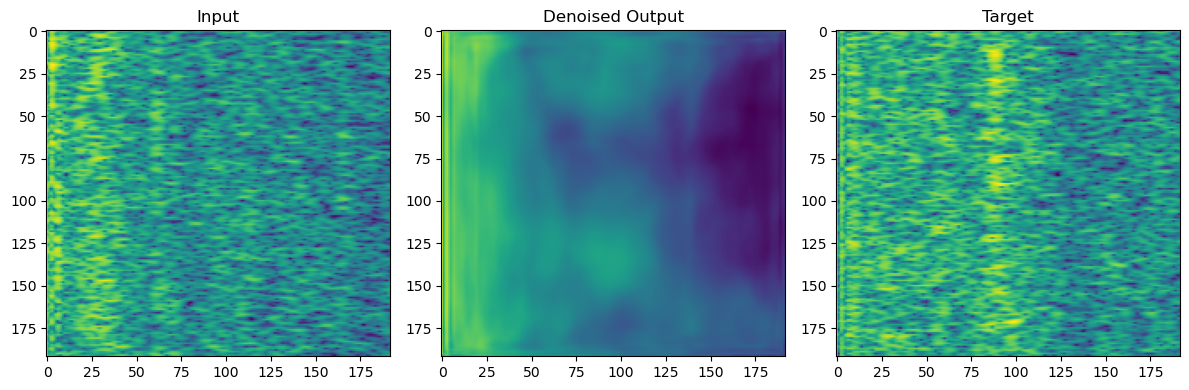

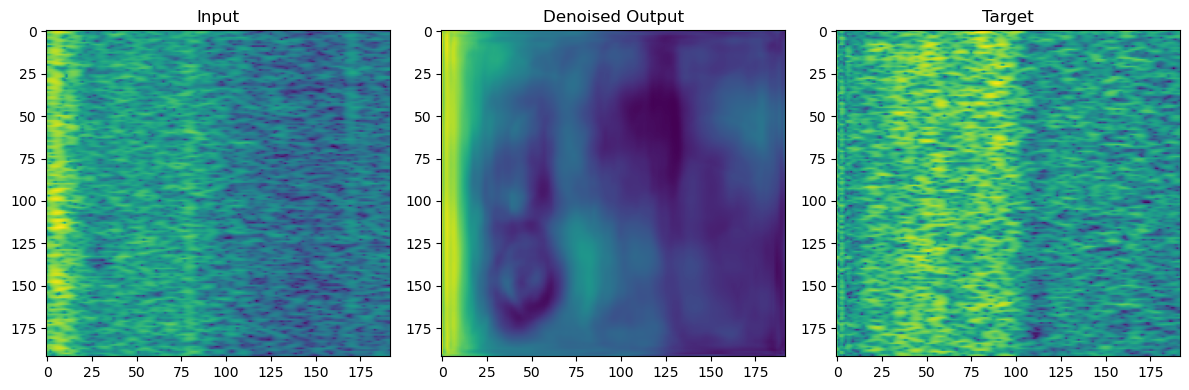

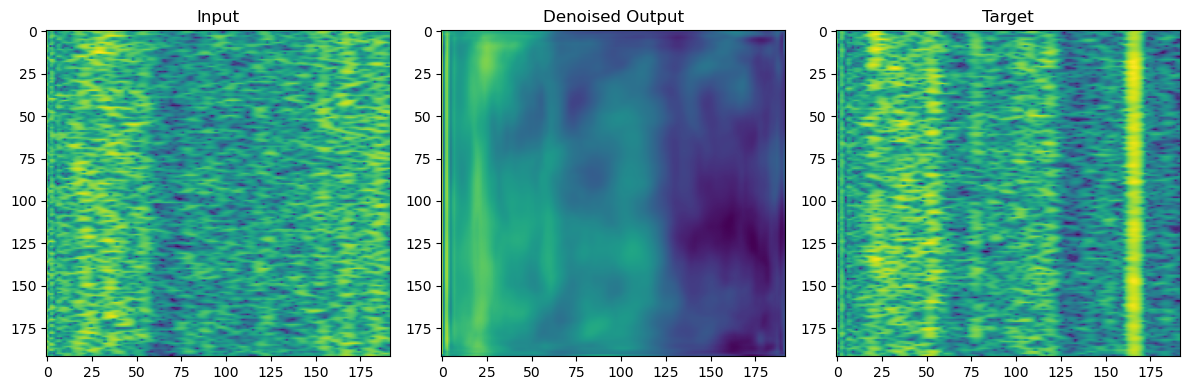

In [21]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    plt.figure(figsize=(12, 4))
    
    # INPUT
    plt.subplot(1, 3, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Input")
    # plt.colorbar()

    # DENOISED OUTPUT
    plt.subplot(1, 3, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    # plt.colorbar()

    # TARGET
    plt.subplot(1, 3, 3)
    plt.imshow(sample_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Target")
    # plt.colorbar()
    
    plt.tight_layout()
    plt.show()